# Libs

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings('ignore')

import polars as pl
pl.Config.set_tbl_rows(None)

import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


from sklearn.model_selection import train_test_split, cross_val_score
from catboost import CatBoostClassifier, Pool
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score


import data_squeeze_funcs as dsf
import data_loading_funcs as dlf
import modeling_functions as mf
import feature_engineering as fef
import feat_eng_pol as fepl

pygame 2.6.1 (SDL 2.28.4, Python 3.11.0)
Hello from the pygame community. https://www.pygame.org/contribute.html


# 0. Data Loading

In [3]:
df_data = dlf.load_data_pl()
df_target = dlf.load_target_pl()

In [4]:
df_combined = df_data.join(df_target, on="id", how="inner")
one_source = df_combined.sort("rn", descending=True).unique(subset="id", keep="first")

one_source.head(5)

id,rn,pre_since_opened,pre_since_confirmed,pre_pterm,pre_fterm,pre_till_pclose,pre_till_fclose,pre_loans_credit_limit,pre_loans_next_pay_summ,pre_loans_outstanding,pre_loans_max_overdue_sum,pre_loans_credit_cost_rate,pre_loans5,pre_loans530,pre_loans3060,pre_loans6090,pre_loans90,is_zero_loans5,is_zero_loans530,is_zero_loans3060,is_zero_loans6090,is_zero_loans90,pre_util,pre_over2limit,pre_maxover2limit,is_zero_util,is_zero_over2limit,is_zero_maxover2limit,enc_paym_0,enc_paym_1,enc_paym_2,enc_paym_3,enc_paym_4,enc_paym_5,enc_paym_6,enc_paym_7,enc_paym_8,enc_paym_9,enc_paym_10,enc_paym_11,enc_paym_12,enc_paym_13,enc_paym_14,enc_paym_15,enc_paym_16,enc_paym_17,enc_paym_18,enc_paym_19,enc_paym_20,enc_paym_21,enc_paym_22,enc_paym_23,enc_paym_24,enc_loans_account_holder_type,enc_loans_credit_status,enc_loans_credit_type,enc_loans_account_cur,pclose_flag,fclose_flag,flag
i32,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16,bool,bool,bool,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16,bool,bool,i8
1053754,16,12,6,4,8,1,11,13,6,3,2,0,6,16,5,4,8,1,1,1,1,1,18,2,17,false,true,true,0,3,3,3,3,3,3,3,3,3,3,4,3,3,3,3,3,3,3,3,4,3,3,3,4,1,2,4,1,true,true,0
153649,13,19,9,4,8,1,11,17,4,4,2,9,6,16,5,4,8,1,1,1,1,1,12,2,17,false,true,true,0,0,3,3,3,3,3,3,3,3,3,4,3,3,3,3,3,3,3,3,4,3,3,3,4,1,2,3,1,true,true,0
606283,11,12,9,2,8,8,11,4,2,3,2,3,6,16,5,4,8,1,1,1,1,1,16,2,17,true,true,true,0,3,3,3,3,3,3,3,3,3,3,4,3,3,3,3,3,3,3,3,4,3,3,3,4,1,2,3,1,false,true,0
2356603,2,12,2,13,0,12,11,12,1,4,2,2,6,16,5,4,8,1,1,1,1,1,18,2,17,false,true,true,0,0,3,3,3,3,3,3,3,3,3,4,3,3,3,3,3,3,3,3,4,3,3,3,4,1,2,4,1,false,false,0
1932024,22,12,9,4,8,1,11,7,0,5,2,9,6,16,5,4,8,1,1,1,1,1,11,2,17,false,true,true,3,3,3,3,3,3,3,3,3,3,3,4,3,3,3,3,3,3,3,3,4,3,3,3,4,1,2,3,1,true,true,0


# 1. Feature Engineering

In [5]:
one = one_source.clone()

In [7]:
pre_loans_cols = ["pre_loans5", "pre_loans530", "pre_loans3060", "pre_loans6090", "pre_loans90"]
is_zero_loans_cols = [i for i in one.columns if i.startswith('is_zero_')]
enc_paym_sum_cols = [i for i in one.columns if i.startswith('enc_paym_')]

one = one.with_columns(
    pl.sum_horizontal(pre_loans_cols).alias("pre_loans_total").cast(pl.Int8),
    pl.sum_horizontal(is_zero_loans_cols).alias("is_zero_loans_total").cast(pl.Int8),
    pl.sum_horizontal(enc_paym_sum_cols).alias("enc_paym_sum_total").cast(pl.Int16),
)

one = fepl.credit_type_grpd(one)


In [8]:
default = one.filter(pl.col('flag') == 1)
no_def = one.filter(pl.col('flag') != 1)

In [9]:
default_pterm = default.group_by('enc_paym_sum_total').count()
no_def_pterm = no_def.group_by('enc_paym_sum_total').count()

tot_count = default_pterm.join(no_def_pterm, on="enc_paym_sum_total", how="left").sort('enc_paym_sum_total').rename({
    "count": "def_count",
    "count_right": "no_def_count"
})

tot_count = tot_count.with_columns(
    ((pl.col("def_count") / pl.col("no_def_count")) * 100).alias('%')
).sort('enc_paym_sum_total').to_pandas()

tot_count

,enc_paym_sum_total,def_count,no_def_count,%
0,6,1426,77982,1.828627
1,8,243,11306,2.149301
2,10,151,5797,2.604796
3,12,653,42981,1.519276
4,14,253,9795,2.582950
5,16,172,5404,3.182828
6,18,253,13814,1.831475
7,20,162,4506,3.595206
8,22,133,3119,4.264187
9,24,250,13222,1.890788


In [10]:
tot_count.describe()

,enc_paym_sum_total,def_count,no_def_count,%
count,76.000000,76.000000,76.000000,76.000000
mean,81.000000,1400.552632,38073.131579,4.812804
std,44.166352,3145.458819,72773.514812,2.797367
min,6.000000,98.000000,1098.000000,1.519276
25%,43.500000,177.500000,3953.500000,2.550644
50%,81.000000,386.500000,9541.500000,4.232934
75%,118.500000,927.750000,21360.750000,6.127298
max,156.000000,19561.000000,377392.000000,16.575592


In [13]:
tot_count[(tot_count['%'] > 4.23) & (tot_count['%'] < 6.13)].values[:,0].astype('int').tolist()

[22,
 28,
 32,
 38,
 40,
 46,
 50,
 52,
 58,
 64,
 70,
 88,
 92,
 98,
 104,
 110,
 116,
 150,
 156]

In [41]:
# default_by_type = default.group_by("rn").agg(
#     ((pl.col("pre_since_opened") + pl.col("pre_till_pclose")))
#     .mean()
#     .alias("time_limit_def")
# ).sort("rn")

# no_def_by_type = no_def.group_by("rn").agg(
#     ((pl.col("pre_since_opened") + pl.col("pre_till_pclose")))
#     .mean()
#     .alias("time_limit_nodef")
# ).sort("rn")

# tot_count2 = pl.concat(
#     [default_by_type, no_def_by_type.drop("rn")], 
#     how="horizontal"
# ).to_pandas()

# # tot_count = tot_count.with_columns(
# #     ((pl.col('def_count') / pl.col('no_def_count')) * 100).alias('%')
# # )
# tot_count2

In [91]:
cols_to_skip = ['rn', 'id']
default_by_type = default.group_by("enc_loans_credit_type").agg(
    pl.count().alias("def_count")
).sort("enc_loans_credit_type")
default_by_type

enc_loans_credit_type,def_count
i16,u32
0,1692
1,1828
2,1094
3,42359
4,50860
5,7835
6,243
7,531


In [92]:
no_def_by_type = no_def.group_by("enc_loans_credit_type").agg(
    pl.count().alias("no_def_count"),
).sort("enc_loans_credit_type")
no_def_by_type

enc_loans_credit_type,no_def_count
i16,u32
0,109161
1,67037
2,52422
3,1105267
4,1442247
5,94754
6,4902
7,17768


In [94]:
util_no_overdue_def = default.select(
    (pl.col('pre_maxover2limit') * pl.col('enc_paym_sum_total')).mean()
)

util_no_overdue_nodef = no_def.select(
    (pl.col('pre_maxover2limit') * pl.col('enc_paym_sum_total')).mean()
)

util_no_overdue_def - util_no_overdue_nodef

pre_maxover2limit
f64
62.678394


In [108]:
one = one.with_columns(
    (pl.col("pre_util") * pl.col("is_zero_loans_total")).alias('util_no_overdue').cast(pl.Int16),
    (pl.col("enc_loans_credit_type").is_in([3,4,5,6])).alias('problem_type').cast(pl.Boolean),
)

In [109]:
cols_to_drop = ["is_zero_loans_total", ]
one = one.drop(pre_loans_cols + is_zero_loans_cols + enc_paym_sum_cols + cols_to_drop)
one

id,rn,pre_since_opened,pre_since_confirmed,pre_pterm,pre_fterm,pre_till_pclose,pre_till_fclose,pre_loans_credit_limit,pre_loans_next_pay_summ,pre_loans_outstanding,pre_loans_total_overdue,pre_loans_max_overdue_sum,pre_loans_credit_cost_rate,pre_util,pre_over2limit,pre_maxover2limit,enc_loans_account_holder_type,enc_loans_credit_status,enc_loans_credit_type,enc_loans_account_cur,pclose_flag,fclose_flag,flag,pre_loans_total,util_no_overdue,problem_type
i32,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16,i8,i8,i16,bool
1280019,8,12,2,11,16,14,8,15,2,1,0,2,8,6,2,17,1,2,4,1,0,0,0,39,84,true
2568553,23,12,10,1,8,14,11,0,0,1,0,2,13,6,2,17,1,2,4,1,0,1,0,39,84,true
212126,3,19,9,4,8,1,11,17,4,2,0,2,9,15,2,17,1,2,3,1,1,1,0,39,210,true
2779443,5,19,10,17,8,8,11,10,2,3,0,2,0,16,2,17,1,2,3,1,0,1,0,39,256,true
1451344,6,12,2,1,8,14,11,15,5,1,0,2,2,6,2,17,1,2,4,1,0,1,0,39,84,true
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
637788,6,12,6,4,8,1,11,17,2,3,0,2,2,16,2,17,1,2,3,1,1,1,0,39,256,true
979947,4,2,9,4,8,1,11,17,2,3,0,1,5,16,2,3,1,2,4,1,1,1,0,39,192,true
325956,7,9,0,11,13,14,8,15,5,1,0,2,8,11,2,17,1,2,4,1,0,0,0,39,154,true


# 3. Modeling

In [110]:
df_model = one.to_pandas()

X = df_model.drop(columns=['flag', 'id'])
y = df_model.flag

In [111]:
message = 'problem type'

(3000000, 18)


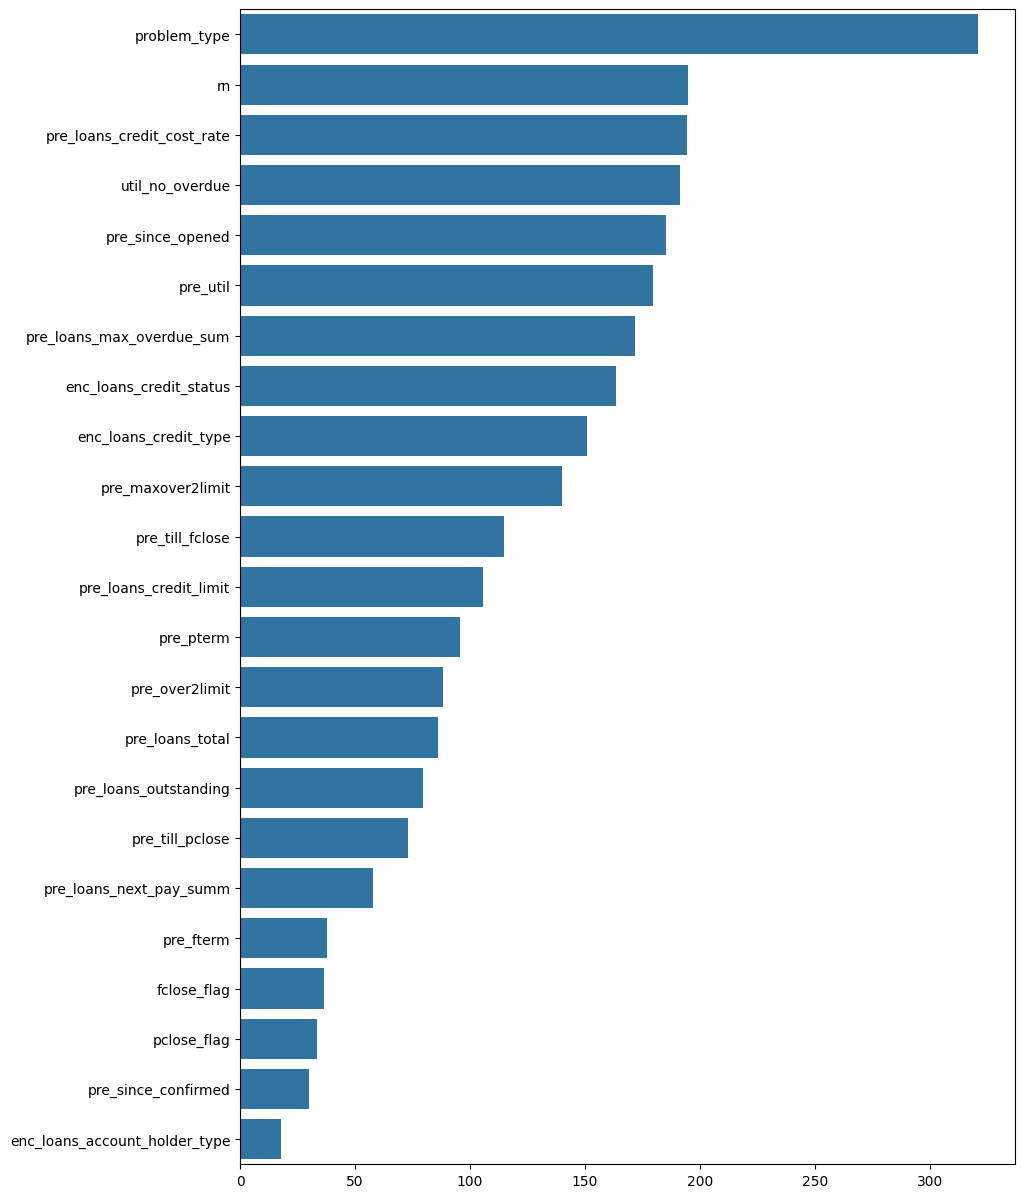

In [112]:
# Создание и обучение модели
xgb = XGBClassifier(
    n_estimators=1000,
    max_depth=4,
    learning_rate=0.012,
    random_state=137,
    verbosity=0,
    eval_metric='auc',
    tree_method='gpu_hist',
    enable_categorical=True
)

xgb.fit(X, y)

# Получение важности признаков
feature_importance = xgb.get_booster().get_score(importance_type='gain')

# Сортировка важности признаков
best_features_sorted = dict(
    sorted(feature_importance.items(), key=lambda item: item[1], reverse=True)
)

# Визуализация важности признаков
plt.figure(figsize=(10, 15))
sns.barplot(
    x=list(best_features_sorted.values()), 
    y=list(best_features_sorted.keys())
)

# Фильтрация признаков для нового DataFrame
feats_to_df_model = [feat for feat, val in best_features_sorted.items() if val > 50]
df_lessened = X[feats_to_df_model].copy()
# df_lessened['flag'] = df_model['flag']

# Размер итогового DataFrame
print(df_lessened.shape)


In [113]:
X = df_lessened
y = df_model.flag


X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=137
)

In [ ]:
xgb_best_params = {
    'n_estimators': 1000,
    'max_depth': 4,
    'learning_rate': 0.01,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    # 'scale_pos_weight': 10,  # Балансировка классов
    'gamma': 1,
    'min_child_weight': 5,
    'reg_alpha': 0.1,
    'reg_lambda': 1,
    'random_state': 137,
    'tree_method': 'gpu_hist',  # Использование GPU
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'enable_categorical': True
}

def print_and_write(model, message, score):
    with open("results.txt", "a") as f:
        string = f"AUC on CV with {message:40}: {score:.2%}"
        print(string)
        f.write(f"\n{type(model).__name__}\n{string}\n")


In [45]:
xgb = XGBClassifier(**xgb_best_params)
xgb.fit(X_train, y_train)

y_pred = xgb.predict_proba(X_test)[:, 1]
score = roc_auc_score(y_test, y_pred)

print_and_write(xgb, message, score)


AUC on CV with one                                     : 69.45%


In [29]:
xgb = XGBClassifier(**xgb_best_params)

cv = cross_val_score(xgb, X, y, cv=5, scoring='roc_auc')
cv_mean = cv.mean()


AUC on CV with one                                     : 69.79%


In [ ]:
mean_pterm_def =  default.group_by("enc_loans_credit_type_grouped").agg(
    # (pl.col("pre_util") * pl.col("is_zero_loans_total")).mean().alias('def_count'),
    (pl.col("pre_pterm")).mean().alias('count_def')
).sort('enc_loans_credit_type_grouped')
mean_pterm_nodef =  no_def.group_by("enc_loans_credit_type_grouped").agg(
    # (pl.col("pre_util") * pl.col("is_zero_loans_total")).mean().alias('no_def_count'),
    (pl.col("pre_pterm")).mean().alias('count_nodef')
).sort('enc_loans_credit_type_grouped')
mean_pterm = one.group_by('enc_loans_credit_type_grouped').agg(
    pl.col('pre_pterm').mean().alias('count_total')
)


tot_count = pl.concat(
    [mean_pterm, mean_pterm_def.drop('enc_loans_credit_type_grouped'), mean_pterm_nodef.drop('enc_loans_credit_type_grouped')],
    how='horizontal'
)

tot_count = tot_count.with_columns(
    ((pl.col('count_nodef') - pl.col('count_def'))).alias('diff')
).sort('enc_loans_credit_type_grouped')
tot_count


enc_loans_credit_type_grouped,count_total,count_def,count_nodef,diff
i16,f64,f64,f64,f64
0,6.91816,10.482408,10.173669,-0.308739
1,10.182025,7.482412,6.908431,-0.573981
2,8.057755,7.96593,8.061115,0.095186
3,6.522704,5.264546,6.624689,1.360143
